# CL for multi-annotator data [cifar10h] [benchmarking]
- This notebook uses the results from the model_train_pred notebook to evaluate model performance. Also evaluates general multi-annotator dataset health

In [63]:
%load_ext autoreload
%autoreload 2

import cleanlab
from cleanlab.rank import get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.internal.label_quality_utils import get_normalized_entropy
from cleanlab.filter import find_label_issues
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score, log_loss
from matplotlib import pyplot as plt

sys.path.insert(0, "../")
from utils.eval_metrics import lift_at_k
from utils.active_learning_scores import least_confidence
# experimental version of label quality ensemble scores with additional weighting schemes
from utils.label_quality_ensemble_scores_experimental import get_label_quality_ensemble_scores_experimental

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
!pwd

/Users/uly/Documents/Cleanlab/multiannotator_benchmarks


### Load/Analyze Cifar10h Data

In [65]:
# If this line throws an error, make sure you correctly downloaded and unzipped cifar10h-raw data

pred_probs_multiannotator = np.load('./data/cifar10h/cifar10h-probs.npy')
df = pd.read_csv('./data/cifar10h/cifar10h-raw.csv')
df = df[df.cifar10_test_test_idx != -99999] # dropping all attention check trials
df.head()

,annotator_id,trial_index,is_attn_check,true_category,chosen_category,true_label,chosen_label,correct_guess,cifar10_test_test_idx,image_filename,subcategory,reaction_time,time_elapsed
0,0,0,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1342,1342
1,0,1,0,deer,horse,4,7,0,1118,alces_alces_s_000236.png,alces_alces,4305,6244
2,0,2,0,horse,horse,7,7,1,5965,stud_mare_s_001236.png,stud_mare,2811,9274
3,0,3,0,truck,automobile,9,1,0,6167,delivery_van_s_000100.png,delivery_van,1136,10610
4,0,4,0,deer,bird,4,2,0,373,elk_s_000359.png,elk,4410,15994


In [66]:
df.describe()

,annotator_id,trial_index,is_attn_check,true_label,chosen_label,correct_guess,cifar10_test_test_idx,reaction_time,time_elapsed
count,514200.000000,514200.000000,514200.0,514200.000000,514200.000000,514200.000000,514200.000000,5.142000e+05,5.142000e+05
mean,1285.000000,104.000000,0.0,4.500000,4.525208,0.948744,5000.431614,1.935603e+03,2.931535e+05
std,742.184437,60.592963,0.0,2.872284,2.870586,0.220520,2886.618758,1.162328e+04,2.222935e+05
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-6.277500e+04,4.810000e+02
25%,642.000000,51.750000,0.0,2.000000,2.000000,1.000000,2502.000000,1.206000e+03,1.371220e+05
50%,1285.000000,104.000000,0.0,4.500000,5.000000,1.000000,5000.000000,1.483000e+03,2.709670e+05
75%,1928.000000,156.250000,0.0,7.000000,7.000000,1.000000,7500.000000,1.969000e+03,4.106732e+05
max,2570.000000,208.000000,0.0,9.000000,9.000000,1.000000,9999.000000,7.686536e+06,9.029878e+06


#### restructure dataset information
- num_datapoints (N), num_annotators (M)
- labels: (N,M)
- labels_error_mask: (N,M) where True=error
- annotator_mask: (N,M) where True=annotator x anotated that
- true_labels: (K=10,000,) # indexed same way as cifar10
- true_images: (K=10,000,)

In [67]:
# get annotations per annotator in numpy array (rows = annotations, cols = annotators)

num_datapoints = df['cifar10_test_test_idx'].max() + 1
num_annotators = df['annotator_id'].max() + 1

labels = np.full((num_datapoints, num_annotators), np.nan) # all annotator labels np.full([height, width, 9], np.nan)
labels_error_mask = np.zeros((num_datapoints, num_annotators), dtype=bool) # mask of annotator errors
annotator_mask = np.zeros((num_datapoints, num_annotators), dtype=bool) # mask of what each person annotated

print(labels.shape, labels.sum(), labels_error_mask.shape, labels_error_mask.sum(), annotator_mask.shape, annotator_mask.sum())

for annotator_id in range(num_annotators):
    adf = df[df.annotator_id == annotator_id] # 200 annotations per annotator
    annotations_idx = adf['cifar10_test_test_idx'].values
    annotations = adf['chosen_label'].values
    errors = adf['correct_guess'].values
    
    labels[annotations_idx, annotator_id] = annotations
    labels_error_mask[annotations_idx, annotator_id] = errors
    annotator_mask[annotations_idx, annotator_id] = True

print(labels.shape, labels.sum(), labels_error_mask.shape, labels_error_mask.sum(), annotator_mask.shape, annotator_mask.sum())

(10000, 2571) nan (10000, 2571) 0 (10000, 2571) 0
(10000, 2571) nan (10000, 2571) 487844 (10000, 2571) 514200


In [68]:
# get true labels as numpy array (rows = true labels,) and true images

true_labels = np.zeros((num_datapoints, ))

idx_to_label = \
[(idx,label,image) for idx,label,image in zip(df['cifar10_test_test_idx'],df['true_label'],df['image_filename'])]
idx_to_label = list(set(idx_to_label))

idx = [idx_to_label[0] for idx_to_label in idx_to_label]
true_label = [idx_to_label[1] for idx_to_label in idx_to_label]
true_images = [idx_to_label[2] for idx_to_label in idx_to_label]

true_labels[idx] = true_label

#### get accuracy of individual annotators

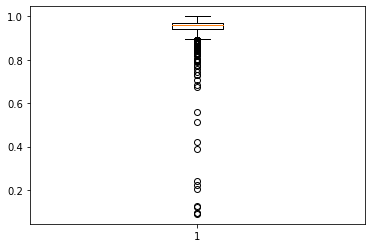

,score
count,2571.000000
mean,0.948744
std,0.057286
min,0.090000
25%,0.940000
50%,0.960000
75%,0.970000
max,1.000000


In [69]:
# Get accuracy of individual annotators
def plt_annotator_accuracy(labels_error_mask, annotator_mask):
    annotator_accuracy = labels_error_mask.sum(axis=0) / annotator_mask.sum(axis=0)
    plt.boxplot(annotator_accuracy)
    plt.show()

    df_describe = pd.DataFrame(annotator_accuracy, columns=['score'])
    return df_describe

df_describe = plt_annotator_accuracy(labels_error_mask, annotator_mask)
df_describe.describe()

#### get accuracy of consensus labels

In [70]:
# Compute the consensus_labels
# TODO: conditional based on consensus_method, consensus_method can be a List[str], add dawid-skene
def get_consensus_labels(labels_multiannotator, pred_probs):
    mode_labels_multiannotator = labels_multiannotator.mode(axis=1)
    consensus_labels = []
    for i in range(len(mode_labels_multiannotator)):
        consensus_labels.append( int(mode_labels_multiannotator.iloc[i][pred_probs[i][mode_labels_multiannotator.iloc[i].dropna().astype(int).to_numpy()
                    ].argmax()
                ]
            )
        )
    return np.array(consensus_labels)

def get_consensus_accuracy_report(labels, true_labels, annotator_mask, pred_probs_multiannotator):
    labels_multiannotator = pd.DataFrame(labels)
    consensus_labels = get_consensus_labels(labels_multiannotator, pred_probs_multiannotator)
    correct_consensus = (true_labels == consensus_labels) + 0
    all_consensus = [1] * len(true_labels)
    correct_consensus.sum() / len(correct_consensus)

    num_annotators_per_example = annotator_mask.sum(axis=1)

    consensus_accuracy = pd.DataFrame(zip(correct_consensus, num_annotators_per_example,all_consensus), columns=['consense','num_a','total_seen'])
    consensus_accuracy = consensus_accuracy.groupby('num_a')[["consense", "total_seen"]].sum().reset_index()
    consensus_accuracy['consensus_acc'] = consensus_accuracy['consense'] / consensus_accuracy['total_seen']
    return consensus_accuracy'

# per example, number of annotators that agree with consensus label (% agreement = x with lower confidence bound = confidence interval for true proportion of annotators that greed (jonas share))
# plot accuracy of consensus label given number of annotators that agree
# if acc to num annotators and num annotator agreement % then we perform best

def plot_labels_multiannotator(labels, pred_probs_multiannotator=None):
    labels_multiannotator = pd.DataFrame(labels)
    
    if pred_probs_multiannotator is None:
        pred_counts = labels.sum(axis=1)
        pred_probs_multiannotator = labels / pred_counts[:,np.newaxis]

    consensus_labels = get_consensus_labels(labels_multiannotator, pred_probs_multiannotator)
    consensus_labels_tile = np.repeat(consensus_labels[:,np.newaxis], labels_multiannotator.shape[1], axis=1)
    num_annotators_per_ex = np.count_nonzero(~np.isnan(labels), axis=1)
    annotator_agreement = (labels_multiannotator == consensus_labels_tile) # Number of annotators matches consensus
    annotator_agreement = annotator_agreement.sum(axis=1)
    bin_consensus = (true_labels == consensus_labels) + 0
    consensus_accuracy = pd.DataFrame(zip(annotator_agreement,bin_consensus), columns=['annotator_agreement','bin_consense'])
    _ = consensus_accuracy.boxplot(by=['bin_consense'], figsize=(7,7))
    consensus_accuracy = consensus_accuracy.groupby('bin_consense')[['annotator_agreement']].sum().reset_index()

    return consensus_accuracy


    

,bin_consense,annotator_agreement
0,0,2326
1,1,486587


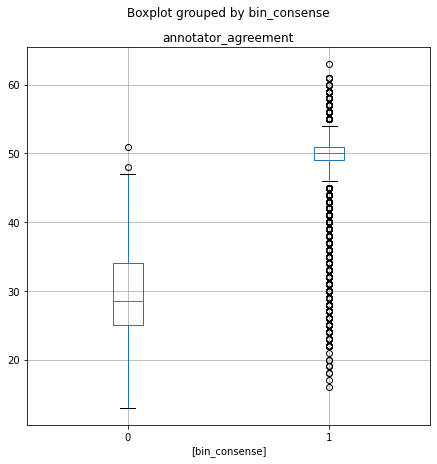

In [74]:
plot_labels_multiannotator(labels)

In [75]:
consensus_accuracy = get_consensus_accuracy_report(labels, 
                              true_labels, 
                              annotator_mask, 
                              pred_probs_multiannotator)
consensus_accuracy

,num_a,consense,total_seen,consensus_acc
0,50,2798,2816,0.993608
1,51,3332,3362,0.991077
2,52,2161,2181,0.990830
3,53,979,986,0.992901
4,54,339,341,0.994135
5,55,93,95,0.978947
6,56,36,36,1.000000
7,57,80,80,1.000000
8,58,49,49,1.000000
9,59,38,38,1.000000


<AxesSubplot:xlabel='num_a'>

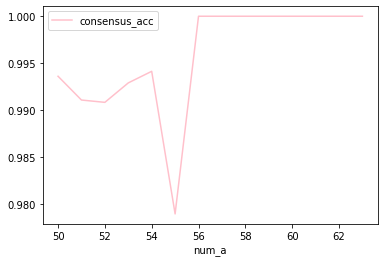

In [76]:
consensus_accuracy[['num_a','consensus_acc']].plot(kind='line',x='num_a',y='consensus_acc',color='pink')

In [78]:
# make prec/recall plot for conensus_labels correct/not correct for each example given preds from model are now our scores
# high level: when few annotators. unreliable

### Try random dropout of random number of examples
- randomly flip some 1 bits in annotator mask per row
- apply annotator mask to labels (nan where it is 0) and
- labels_error_mask (false where it is 0)
- calculate new pred_probs multiannotator

In [79]:
# labels- all annotator labels np.full([height, width, 9], np.nan)
# labels_error_mask- mask of annotator errors
# annotator_mask- mask of what each person annotated

def get_sample_labels(x_sample, y_sample, labels, labels_error_mask, annotator_mask):
    s_annotator_mask = annotator_mask.copy()
    s_annotator_mask[(x_sample,y_sample)] = 0
    s_labels_error_mask = s_annotator_mask & labels_error_mask
    s_labels = labels.copy()
    np.copyto(s_labels, np.nan, where=s_annotator_mask)
    print('Total idxs dropped: ', annotator_mask.sum() - s_annotator_mask.sum())
    return s_labels, s_labels_error_mask, s_annotator_mask

**randomly drop x percent of all labels**

In [94]:
# randomly drop x percent of all labels
percent_dropped = 0.4

x,y = np.where(annotator_mask == 1)
drop_idx = np.random.choice(np.arange(len(x)), int(len(x)*percent_dropped), replace=False)
x_sample = x[drop_idx]
y_sample = y[drop_idx]
s_labels, s_labels_error_mask, s_annotator_mask = get_sample_labels(x_sample, y_sample, labels, labels_error_mask, annotator_mask)

Total idxs dropped:  205680


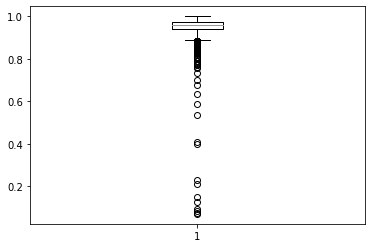

,score
count,2571.000000
mean,0.948642
std,0.059083
min,0.070866
25%,0.938764
50%,0.957983
75%,0.973913
max,1.000000


In [95]:
df_describe = plt_annotator_accuracy(s_labels_error_mask, s_annotator_mask)
df_describe.describe()

In [96]:
consensus_accuracy = get_consensus_accuracy_report(s_labels, 
                              true_labels, 
                              s_annotator_mask, 
                              pred_probs_multiannotator)
consensus_accuracy

,num_a,consense,total_seen,consensus_acc
0,15,2,2,1.000000
1,16,1,1,1.000000
2,17,2,2,1.000000
3,19,3,3,1.000000
4,20,11,12,0.916667
5,21,27,27,1.000000
6,22,68,68,1.000000
7,23,89,90,0.988889
8,24,194,195,0.994872
9,25,288,288,1.000000


<AxesSubplot:xlabel='num_a'>

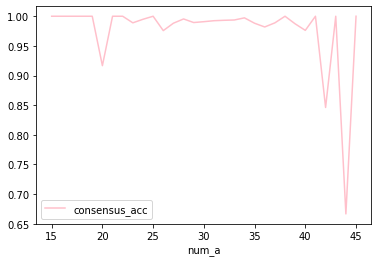

In [97]:
consensus_accuracy[['num_a','consensus_acc']].plot(kind='line',x='num_a',y='consensus_acc',color='pink')
# x axis can be lower bound on consensus labels (i.e. how many annotators agreed)

,bin_consense,annotator_agreement
0,0,1139
1,1,194561


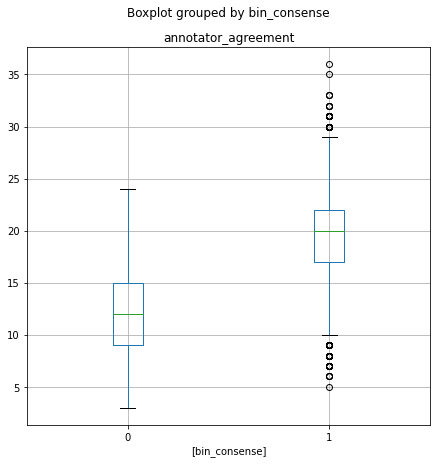

In [98]:
plot_labels_multiannotator(s_labels)

**Drop x rows per every annotator**

In [99]:
percent_dropped = 0.4
rows_dropped = int(200 * percent_dropped)
print('rows dropped: ', rows_dropped)

x,y = np.where(annotator_mask == 1)
df_delete = pd.DataFrame(zip(x,y),columns=['x','y'])
df_keep = df_delete.drop(df_delete.groupby('y').sample(n=200 - rows_dropped).index)
x_sample,y_sample = df_keep['x'].values, df_keep['y'].values
s_labels, s_labels_error_mask, s_annotator_mask = get_sample_labels(x_sample, y_sample, labels, labels_error_mask, annotator_mask)

rows dropped:  80
Total idxs dropped:  205680


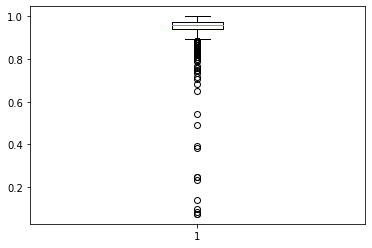

,score
count,2571.000000
mean,0.948642
std,0.058748
min,0.075000
25%,0.941667
50%,0.958333
75%,0.975000
max,1.000000


In [100]:
df_describe = plt_annotator_accuracy(s_labels_error_mask, s_annotator_mask)
df_describe.describe()

In [101]:
consensus_accuracy = get_consensus_accuracy_report(s_labels, 
                              true_labels, 
                              s_annotator_mask, 
                              pred_probs_multiannotator)
consensus_accuracy

,num_a,consense,total_seen,consensus_acc
0,16,1,1,1.000000
1,17,1,1,1.000000
2,18,3,3,1.000000
3,19,3,3,1.000000
4,20,20,20,1.000000
5,21,36,36,1.000000
6,22,38,39,0.974359
7,23,109,109,1.000000
8,24,199,201,0.990050
9,25,279,281,0.992883


<AxesSubplot:xlabel='num_a'>

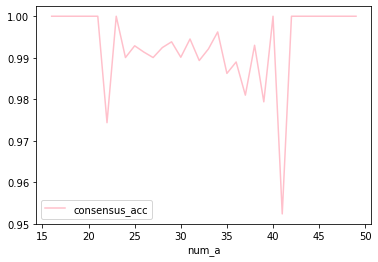

In [102]:
consensus_accuracy[['num_a','consensus_acc']].plot(kind='line',x='num_a',y='consensus_acc',color='pink')

,bin_consense,annotator_agreement
0,0,1036
1,1,194634


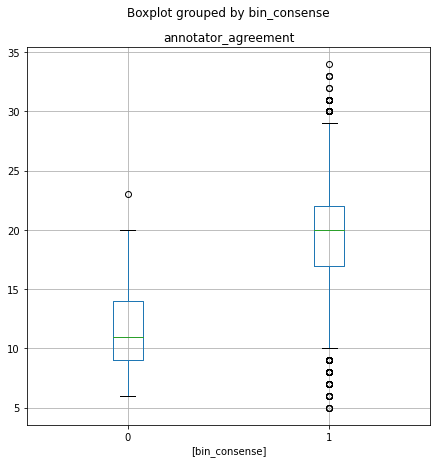

In [103]:
plot_labels_multiannotator(s_labels)

**Drop x values for every row**

In [108]:
# rows have min 50 values
percent_dropped = 0.4
vals_dropped = int(50 * percent_dropped)
print('vals dropped: ', vals_dropped)

x,y = np.where(annotator_mask == 1)
df_delete = pd.DataFrame(zip(x,y),columns=['x','y'])
df_keep = df_delete.drop(df_delete.groupby('x').sample(n=50 - vals_dropped).index)
x_sample,y_sample = df_keep['x'].values, df_keep['y'].values
s_labels, s_labels_error_mask, s_annotator_mask = get_sample_labels(x_sample, y_sample, labels, labels_error_mask, annotator_mask)

vals dropped:  20
Total idxs dropped:  214200


In [109]:
consensus_accuracy = get_consensus_accuracy_report(s_labels, 
                              true_labels, 
                              s_annotator_mask, 
                              pred_probs_multiannotator)
consensus_accuracy

,num_a,consense,total_seen,consensus_acc
0,30,9914,10000,0.9914


,bin_consense,annotator_agreement
0,0,1054
1,1,202793


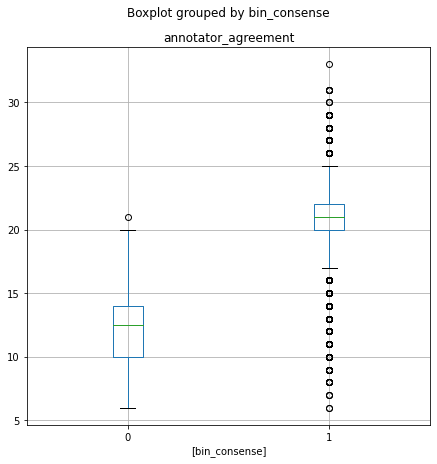

In [110]:
plot_labels_multiannotator(s_labels)

### Load models and data

In [115]:
# dictionaries to map to display name
method_adjust_pred_probs_display_dict = {
    "self_confidence-False": "Self Confidence",
    "self_confidence-True": "Adjusted Self Confidence",
    "normalized_margin-False": "Normalized Margin",
    "normalized_margin-True": "Adjusted Normalized Margin",
    "confidence_weighted_entropy-False": "Confidence Weighted Entropy",
    "entropy-False": "Entropy",
    "least_confidence-False": "Least Confidence",
}

model_display_name_dict = {"resnet18": "ResNet-18",}

models = ["resnet18"] # can also be: "resnet50d", "efficientnet_b1", "twins_pcpvt_base", "swin_base_patch4_window7_224"

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

In [116]:
# read numpy files from model_train_pred
numpy_out_folder = './data/model_data_070522/'
pred_probs = np.load(numpy_out_folder + "test_pred_probs.npy")
pred_labels = np.load(numpy_out_folder + "test_preds.npy")
true_labels = np.load(numpy_out_folder + "test_labels.npy")
images = np.load(numpy_out_folder + "test_images.npy", allow_pickle=True)


# boolean mask of label errors
labels = pred_labels # labels can change to annotator labels!!
label_errors_target = labels != true_labels

In [117]:
%%time
results = []
results_list = []
for score_param in score_params:
    method, adjust_pred_probs = score_param
    # compute scores
    label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)
    # compute accuracy of detecting label errors
    auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)
    # compute Lift@K evaluation metric
    lift_at_k_dict = {}
    for k in range(1000, 11000, 1000):
        lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_scores, k=k)
    # save results
    results = {
        "dataset": "cifar10",
        "model": "resnet18",
        "noise_config": "Noise Amount: 0.2 | Sparsity: 0.4",
        "method": method,
        "adjust_pred_probs": adjust_pred_probs,
        "auroc": auroc
    }
    # add the lift at k metrics
    results.update(lift_at_k_dict)
    # save results
    results_list.append(results)

CPU times: user 493 ms, sys: 3.27 ms, total: 496 ms
Wall time: 505 ms


In [118]:
# Create dataframe and export to csv
df_result = pd.DataFrame(results_list)
# ts = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
# df.to_csv(f"label_quality_scores_evaluation_{ts}.csv", index=False)
df_result.to_csv(f"./data/benchmark_results/label_quality_scores_evaluation.csv", index=False)
df_result

# plot auroc, auprc area under prec v. rec curve (usually similar to auroc but different under imbalanced data (more sensitive to positive class))

,dataset,model,noise_config,method,adjust_pred_probs,auroc,lift_at_1000,lift_at_2000,lift_at_3000,lift_at_4000,lift_at_5000,lift_at_6000,lift_at_7000,lift_at_8000,lift_at_9000,lift_at_10000
0,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,self_confidence,False,0.920512,7.769784,4.448441,3.085532,2.344125,1.913669,1.614708,1.397739,1.238010,1.111111,1.0
1,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,self_confidence,True,0.915362,7.673861,4.448441,3.061551,2.344125,1.894484,1.606715,1.387461,1.229017,1.105782,1.0
2,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,normalized_margin,False,0.930601,7.721823,4.544365,3.141487,2.398082,1.932854,1.626699,1.404591,1.250000,1.111111,1.0
3,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,normalized_margin,True,0.924844,7.649880,4.484412,3.101519,2.380096,1.923261,1.614708,1.401165,1.235012,1.105782,1.0
4,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,confidence_weighted_entropy,False,0.910547,7.482014,4.328537,3.037570,2.320144,1.884892,1.610711,1.394313,1.235012,1.108447,1.0


In [ ]:
# plot auroc

### Run find_label_issues on the consensus labels.

In [119]:
# annotator_id = 1

# adf = df[df.annotator_id == annotator_id] # 200 annotations per annotator
# annotations_idx = adf['cifar10_test_test_idx'].values
# annotations = adf['chosen_label'].values

label_issues = find_label_issues(labels=consensus_labels,
                    pred_probs=pred_probs,
                    return_indices_ranked_by='self_confidence',)

In [132]:
# index images correctly
classes = {"airplane": 0, 
           "automobile": 1, 
           "bird": 2, 
           "cat": 3, 
           "deer": 4, 
           "dog": 5, 
           "frog": 6, 
           "horse": 7, 
           "ship": 8, 
           "truck": 9}

test_indexes = [int(x.split('/')[-1][:4]) for x in images]
print(len(test_indexes), len(set(test_indexes)))
print(images[373])

10000 1000
/datasets/ulyana/multiannotator_benchmarks/data/cifar10/test/automobile/0033.png


In [151]:
# def unpickle(file):
#     import pickle
#     with open(file, 'rb') as fo:
#         dict = pickle.load(fo, encoding='bytes')
#     return dict

# test_batchb = unpickle('./data/cifar10/test_batch')
# test_batch = {}
# for key, value in test_batchb.items(): test_batch[key.decode("utf-8")] = value
# filenames = [file.decode("utf-8") for file in test_batch['filenames']]

In [153]:
# filenames[:10]

['domestic_cat_s_000907.png',
 'hydrofoil_s_000078.png',
 'sea_boat_s_001456.png',
 'jetliner_s_001705.png',
 'green_frog_s_001658.png',
 'crapaud_s_002124.png',
 'shooting_brake_s_000973.png',
 'green_frog_s_000634.png',
 'tabby_cat_s_001397.png',
 'wagon_s_002806.png']

In [154]:
images[:10]

array(['/datasets/ulyana/multiannotator_benchmarks/data/cifar10/test/automobile/0210.png',
       '/datasets/ulyana/multiannotator_benchmarks/data/cifar10/test/automobile/0051.png',
       '/datasets/ulyana/multiannotator_benchmarks/data/cifar10/test/automobile/0461.png',
       '/datasets/ulyana/multiannotator_benchmarks/data/cifar10/test/automobile/0937.png',
       '/datasets/ulyana/multiannotator_benchmarks/data/cifar10/test/automobile/0085.png',
       '/datasets/ulyana/multiannotator_benchmarks/data/cifar10/test/automobile/0748.png',
       '/datasets/ulyana/multiannotator_benchmarks/data/cifar10/test/automobile/0415.png',
       '/datasets/ulyana/multiannotator_benchmarks/data/cifar10/test/automobile/0209.png',
       '/datasets/ulyana/multiannotator_benchmarks/data/cifar10/test/automobile/0052.png',
       '/datasets/ulyana/multiannotator_benchmarks/data/cifar10/test/automobile/0440.png'],
      dtype=object)

In [120]:
print((true_labels == consensus_labels).sum())
testing_true_labels = np.argmax(pred_probs, axis=1)
print((testing_true_labels == consensus_labels).sum())

990
990


In [ ]:
# Run cleanlab on consensus labels (get_label_quality_function)

# High level: how good are all the scores?